In [1]:
import tensorflow as tf
import numpy as np
import pickle
import itertools

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_model(shape):
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.3))
    model.add(LSTM(200, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(shape[1]))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

def train_model(model, X, y, val_data, epochs=10, batch_size=50):
    history = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size)
    return history
    
def save(model, name):
    model_json = model.to_json()
    with open(name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + '.h5')

def load(name):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return model

In [4]:
def get_sonnets(filename):
    """ Returns entire txt file as string. """
    str = ""
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line.isdigit() == False and len(line) > 0:
                str += line.lower().translate(str.maketrans('', '', ':;,.?!()')) + "\n"
    return str

In [5]:
file = 'data/shakespeare.txt'
sons = get_sonnets(file)

print ("# chars in txt: " + str(len(sons)))

# chars in txt: 91006


In [6]:
chars = set(sons) # get set of all characters
print(chars)
print ("# unique chars: " + str(len(chars)))

# create mapping of characters to unique ids
dic_char_to_id = dict((c, i) for i, c in enumerate(chars))
dic_id_to_char = dict((i, c) for i, c in enumerate(chars))

{'y', 'l', 't', 'f', 'm', 'q', 's', ' ', 'z', '-', "'", 'n', 'o', 'b', 'g', 'd', 'c', 'a', 'h', 'k', 'i', 'x', 'e', 'r', 'w', 'j', 'v', '\n', 'p', 'u'}
# unique chars: 30


In [7]:
# create input, output sequences

leng = 40
step_size = 2
seqs, nxt_char = [], []
# take all possible subsequences of 40 consecutive characters
for i in range(0, len(sons) - leng, step_size):
    seqs.append(sons[i + leng : i : -1])
    nxt_char.append(sons[i])
print("# seqs: ", len(seqs))

# seqs:  45483


In [12]:
# convert seqs to one-hot encoding
X = np.zeros((len(seqs), leng, len(chars)), dtype=np.bool)
y = np.zeros((len(seqs), len(chars)), dtype=np.bool)

for i, seq in enumerate(seqs):
    for j, char in enumerate(seq):
        X[i, j, dic_char_to_id[char]] = 1
    y[i, dic_char_to_id[nxt_char[i]]] = 1

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
model = get_model((leng, len(chars)))

In [15]:
history = train_model(model, x_train, y_train, (x_test, y_test))

Train on 34112 samples, validate on 11371 samples
Epoch 1/10
34112/34112 [==============================] - 92s 3ms/step - loss: 2.6699 - val_loss: 2.4007
Epoch 2/10
34112/34112 [==============================] - 103s 3ms/step - loss: 2.2211 - val_loss: 2.1005
Epoch 3/10
34112/34112 [==============================] - 136s 4ms/step - loss: 2.0499 - val_loss: 2.0080
Epoch 4/10
34112/34112 [==============================] - 139s 4ms/step - loss: 1.9439 - val_loss: 1.8962
Epoch 5/10
34112/34112 [==============================] - 138s 4ms/step - loss: 1.8547 - val_loss: 1.8391
Epoch 6/10
34112/34112 [==============================] - 142s 4ms/step - loss: 1.7876 - val_loss: 1.7772
Epoch 7/10
34112/34112 [==============================] - 131s 4ms/step - loss: 1.7316 - val_loss: 1.7285
Epoch 8/10
34112/34112 [==============================] - 126s 4ms/step - loss: 1.6800 - val_loss: 1.7049
Epoch 9/10
34112/34112 [==============================] - 132s 4ms/step - loss: 1.6399 - val_loss: 1.70

In [16]:
save(model, 'models/new_BACKW')

#150 units, 200 units, epochs, batch_size, dropout

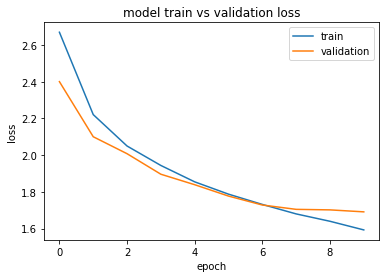

In [23]:
from matplotlib import pyplot

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig('visuals/Shakespeare_200units_10_50_0.3DROPOUT_0.25splitBACKW_loss.png')
pyplot.show()

In [18]:
min(history.history['val_loss']) # 1.7592611852973024

1.6912155579728068

In [19]:
history.history['val_loss'].index(min(history.history['val_loss'])) # 10

9

In [20]:
with open('Shakespeare_200units_10_50_0.3DROPOUT_0.25splitBACKW.pkl', 'wb') as f:
    pickle.dump(history, f)

In [21]:
def sample(preds, temperature = 1.0):
    ''' Helper function to sample an index from
    a probability array. Taken from StackOverflow/
    open source code on GitHub. '''

    preds = np.asarray(preds).astype('float')
    preds = np.log(preds) / temperature
    preds[preds == np.inf] = 0

    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return np.argmax(np.random.multinomial(1, preds, 1))

In [33]:
nchar = 800  # genrated length
for temperature in [0.75, 0.25]:
    print( '\n' + '\n' + 'temperature = ' + str(temp) + '\n')
    
    line = 'shall i compare thee to a summer\'s day \n'
    sentence = line[::-1]
    
    for i in range(nchar):
        x = np.zeros((1, leng, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, dic_char_to_id[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_char = dic_id_to_char[sample(preds, temperature)]

        line = next_char + line
        sentence = sentence[1:] + next_char
        
    print(line)



temperature = 0.25

use
when i fiesmans of the therest is me
this to thes have in other stain
musting theirs the all this diditer less
this thee what i bends and ence more say
were love ensoon more
as twere orrument to love tie that me
but live and me
and there with toust ine to her decore
how i it me to i hate my sue i
no wast the firit to that sall fight
and take when that every renfon
and therest ceay
and thy take winds are thyr thee
warld that a lees of eyes and this heart
for his dete doth not mayl
and i herom in the lied
the that and hear the wornless and
and be it fander of the commelsed-ersed night
steive that seess as where for my reight
the new to thee for thine to lone fear
whose forfest all a more ther is to love
my mire thee i some one were pisture
of the it no it his cone
sos with my deti'st me
shall i compare thee to a summer's day 



temperature = 0.25

hat lest in my love
and for my love therefore the fore
to love that love of thine more ride
the there to love the m